<a href="https://colab.research.google.com/github/kattens/Protein-Interaction-with-LLMs/blob/main/REAL_Second_part_model_after_the_protbert_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Goal of the project:
the purpose of the model is to be able to efficiently change the number of channels which is a new way of introducing different variables and properties to the context of the protein-protein interaction, as well as being able to change the core model of the architecture to see what is the most suitable core for this approach

###different core models to implement:
1. ESM 2
2. Llama 3
3. ProtBert
4. Bert

###different versions of channels:
1. local inputs with faiss
2. local inputs from datasets based on the UniProt database
3. coordinates of the amino acid's Calpha



In [1]:
%%capture
!pip install --upgrade transformers

In [2]:
import pandas as pd
import numpy as np
import torch

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")


True
Tesla T4


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#this is the path for the file
csv_file = '/content/drive/MyDrive/pairs.csv'
pairs_df = pd.read_csv(csv_file)

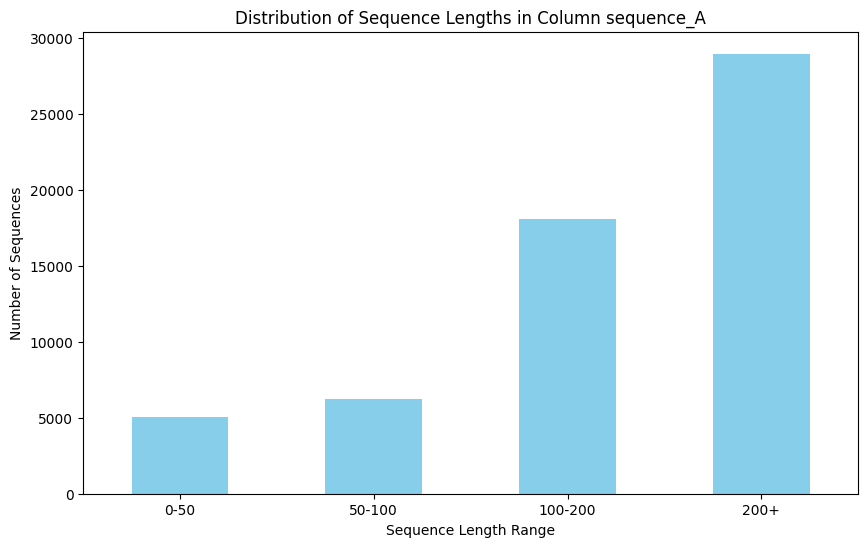

In [6]:
import matplotlib.pyplot as plt

df = pairs_df

# Calculate the lengths of sequences in column 'sequence_A'
df['length'] = df['Sequence_A'].apply(len)

# Define bins for the length ranges
bins = [0, 50, 100, 200, float('inf')]
labels = ['0-50', '50-100', '100-200', '200+']

# Create a new column with binned data
df['length_range'] = pd.cut(df['length'], bins=bins, labels=labels, right=False)

# Count the number of sequences in each range
length_range_counts = df['length_range'].value_counts().sort_index()

# Plotting the data
plt.figure(figsize=(10, 6))
length_range_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Sequence Length Range')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequence Lengths in Column sequence_A')
plt.xticks(rotation=0)
plt.show()


In [7]:
''' if you wanna see that the model i working or not we just add this code here'''
# Read only the first 10 rows of the CSV file
#pairs_df = pd.read_csv(csv_file, nrows=10)

' if you wanna see that the model i working or not we just add this code here'

In [8]:
pairs_df

,pair_id,Protein Name A,Protein Name B,masked_sequence_A,masked_sequence_B,coords_A,coords_B,Embeddings_A,Sequence_A,Embeddings_B,Sequence_B,tokenized_sequence_A,tokenized_sequence_B,tokenized_masked_sequence_A,tokenized_masked_sequence_B,sum_tokenized_sequence_A,sum_tokenized_sequence_B,length,length_range
0,1H0J,1H0J_B,1H0J_C,---------------------------A------------------...,----------------------------T-----------------...,"[(15.18, 27.908, -3.171), (13.094, 28.367, -0....","[(31.71, 11.761, 52.412), (31.514, 9.193, 49.6...","tensor([ 0.1932, -0.0438, 0.7770, 0.2603, -0...",LKCNKLVPLFYKTCPAGKNLCYKMFMVATPKVPVKRGCIDVCPKSS...,"tensor([-1.9606, -0.0789, -1.0516, 1.0233, -1...",LKCNKLVPLFYKTCPAGKNLCYKMFMVATPKVPVKRGCIDVCPKSS...,"[5, 12, 23, 17, 12, 5, 8, 16, 5, 19, 20, 12, 1...","[5, 12, 23, 17, 12, 5, 8, 16, 5, 19, 20, 12, 1...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[37, 44, 55, 49, 44, 37, 40, 48, 37, 51, 52, 4...","[37, 44, 55, 49, 44, 37, 40, 48, 37, 51, 52, 4...",60,50-100
1,1H0J,1H0J_B,1H0J_A,---------------------------------V------------...,---------------------------------V------------...,"[(15.18, 27.908, -3.171), (13.094, 28.367, -0....","[(47.873, 32.351, 21.457), (46.719, 29.304, 23...","tensor([ 0.1932, -0.0438, 0.7770, 0.2603, -0...",LKCNKLVPLFYKTCPAGKNLCYKMFMVATPKVPVKRGCIDVCPKSS...,"tensor([ 0.2015, 0.3117, -0.5839, 1.0137, -0...",LKCNKLVPLFYKTCPAGKNLCYKMFMVATPKVPVKRGCIDVCPKSS...,"[5, 12, 23, 17, 12, 5, 8, 16, 5, 19, 20, 12, 1...","[5, 12, 23, 17, 12, 5, 8, 16, 5, 19, 20, 12, 1...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[37, 44, 55, 49, 44, 37, 40, 48, 37, 51, 52, 4...","[37, 44, 55, 49, 44, 37, 40, 48, 37, 51, 52, 4...",60,50-100
2,1H1A,1H1A_B,1H1A_A,?TL-----GTHN----------------------------------...,?TL-----GTHNG---------------------------------...,"[(1.704, 21.706, 18.319), (-0.901, 24.305, 19....","[(-1.391, 21.605, 15.29), (1.068, 24.346, 14.3...","tensor([ 0.7350, -0.2884, -0.7331, -0.7960, -0...",?TLTSSATGTHNGYYYSFWTDGQGNIRFNLESGGQYSVTWSGNGNW...,"tensor([ 0.1946, -0.4597, -2.2509, -0.3440, -0...",?TLTSSATGTHNGYYYSFWTDGQGNIRFNLESGGQYSVTWSGNGNW...,"[1, 15, 5, 15, 10, 10, 6, 15, 7, 15, 22, 17, 7...","[1, 15, 5, 15, 10, 10, 6, 15, 7, 15, 22, 17, 7...","[1, 15, 5, 32, 32, 32, 32, 32, 7, 15, 22, 17, ...","[1, 15, 5, 32, 32, 32, 32, 32, 7, 15, 22, 17, ...","[2, 30, 10, 47, 42, 42, 38, 47, 14, 30, 44, 34...","[2, 30, 10, 47, 42, 42, 38, 47, 14, 30, 44, 34...",191,100-200
3,1H1I,1H1I_A,1H1I_C,----------------------------------------------...,----------------------------------------------...,"[(65.645, 40.726, 70.958), (67.22, 39.56, 67.6...","[(77.459, 39.1, 34.851), (76.18, 36.721, 37.4)...","tensor([-0.7782, -2.3356, -0.4710, 0.6213, -2...",SSLIVEDAPDHVRPYVIRHYSHARAVTVDTQLYRFYVTGPSSGYAF...,"tensor([-6.7764e-01, 3.7070e-02, 2.5174e-01,...",SSLIVEDAPDHVRPYVIRHYSHARAVTVDTQLYRFYVTGPSSGYAF...,"[10, 10, 5, 11, 8, 9, 14, 6, 16, 14, 22, 8, 13...","[10, 10, 5, 11, 8, 9, 14, 6, 16, 14, 22, 8, 13...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[42, 42, 37, 43, 40, 41, 46, 38, 48, 46, 54, 4...","[42, 42, 37, 43, 40, 41, 46, 38, 48, 46, 54, 4...",344,200+
4,1H1I,1H1I_B,1H1I_C,---------D--------------------------------G---...,---------D--------------------------------G---...,"[(67.215, 3.653, 5.427), (68.427, 7.123, 4.339...","[(77.459, 39.1, 34.851), (76.18, 36.721, 37.4)...","tensor([-0.4936, 1.1125, 1.4919, 0.1379, -1...",SSLIVEDAPDHVRPYVIRHYSHARAVTVDTQLYRFYVTGPSSGYAF...,"tensor([-6.7764e-01, 3.7070e-02, 2.5174e-01,...",SSLIVEDAPDHVRPYVIRHYSHARAVTVDTQLYRFYVTGPSSGYAF...,"[10, 10, 5, 11, 8, 9, 14, 6, 16, 14, 22, 8, 13...","[10, 10, 5, 11, 8, 9, 14, 6, 16, 14, 22, 8, 13...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 3...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 3...","[42, 42, 37, 43, 40, 41, 46, 38, 48, 28, 54, 4...","[42, 42, 37

In [9]:
#theres some values that have ? so we should remove those rows in 'masked_sequence_A', 'masked_sequence_B'
# Remove rows where 'masked_sequence_A' or 'masked_sequence_B' contains '?' anywhere in the sequence
cleaned_df = pairs_df[~(pairs_df['masked_sequence_A'].str.contains('\?', na=False) | pairs_df['masked_sequence_B'].str.contains('\?', na=False))]

# Assign the cleaned DataFrame back to pairs_df
pairs_df = cleaned_df

# Printing the sizes of the original and cleaned dataframes to verify the number of rows removed
print(f"Original DataFrame size: {len(pairs_df)}")
print(f"Cleaned DataFrame size: {len(cleaned_df)}")

Original DataFrame size: 56340
Cleaned DataFrame size: 56340


In [10]:
# Truncate each specified column to a maximum length of 500 characters
columns = ['masked_sequence_A', 'masked_sequence_B', 'Sequence_A', 'Sequence_B']
for col in columns:
    pairs_df[col] = pairs_df[col].apply(lambda x: x[:500] if len(x) > 500 else x)

# Find the longest string by length
pairs_df['Length'] = pairs_df['masked_sequence_A'].apply(len)
longest_string = pairs_df.loc[pairs_df['Length'].idxmax(), 'masked_sequence_A']
print(len(longest_string))


500


<ipython-input-10-e2e2eece8b35>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_df[col] = pairs_df[col].apply(lambda x: x[:500] if len(x) > 500 else x)
<ipython-input-10-e2e2eece8b35>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_df[col] = pairs_df[col].apply(lambda x: x[:500] if len(x) > 500 else x)
<ipython-input-10-e2e2eece8b35>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [11]:
#the number of protein chains we have
pairs_df.shape[0]

56340

Create dataset class that handles both global sequences and local sequences for protein pairs, and potentially prepares for the inclusion of 3D structural data

#the base Model (without coordinates at this point):

  ### Modeling Interactions:
  The mdel could be trained to recognize which amino acids interact by learning representations of local sequences that highlight these interactions. During training, the MLM objective helps the model learn contextual embeddings that are rich in information about which amino acids tend to be near each other and under what structural contexts they interact.

  ### Attention Mechanism:
   The custom attention mechanism can be used to weigh the importance of different amino acids in the global context when predicting the masked amino acids in the local sequences. This allows your model to focus more on the parts of the global sequences that are relevant to the interactions highlighted by the local sequences.

  ### Utilizing Global Sequences:
  While the local sequences are your primary interest, the global sequences provide the context necessary for your model to understand the broader environment in which the interactions occur. Even during prediction, you should feed the model the global sequences to utilize the learned context.

  #### This modular design not only meets your current requirements but also provides a scalable framework to incorporate additional dimensions of protein sequence data analysis in the future


In [12]:
!ls /content/drive/MyDrive/Checkpoints

added_tokens.json     generation_config.json   tokenizer_config.json
config.json	      model.safetensors        tokenizer.json
final_checkpoint.pth  special_tokens_map.json  vocab.txt


In [26]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from torch.quantization import quantize_dynamic
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Define the checkpoint directory and the specific checkpoint file
checkpoint_path = '/content/drive/MyDrive/Checkpoints/final_checkpoint.pth'

# Load the tokenizer first
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Checkpoints')

# Initialize the model from the pre-trained configuration in the Checkpoints directory
model = AutoModelForMaskedLM.from_pretrained('/content/drive/MyDrive/Checkpoints')

# Resize token embeddings in case new tokens were added
model.resize_token_embeddings(len(tokenizer))

# Load the checkpoint into the non-quantized model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
print("Checkpoint loaded successfully into non-quantized model.")

# Move the model to the appropriate device
model = model.to(device)



'''bug is here'''

# Apply dynamic quantization after loading the checkpoint and moving to the device
#model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
print("Model quantized successfully.")





# Reinitialize the optimizer after the model has been resized, loaded, and quantized
optimizer = Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Load the optimizer state if it exists
if 'optimizer_state_dict' in checkpoint:
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Optimizer state loaded successfully.")
    except ValueError as e:
        print(f"Error loading optimizer state: {e}")

# Initialize and load scheduler state if available
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
if 'scheduler_state_dict' in checkpoint:
    try:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Scheduler state loaded successfully.")
    except ValueError as e:
        print(f"Error loading scheduler state: {e}")
else:
    print("No scheduler state found in checkpoint; using default settings.")

print("Model, tokenizer, optimizer, and scheduler loaded from checkpoint, with model quantization applied.")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Checkpoint loaded successfully into non-quantized model.
Model quantized successfully.
Optimizer state loaded successfully.
Scheduler state loaded successfully.
Model, tokenizer, optimizer, and scheduler loaded from checkpoint, with model quantization applied.


#the error is in this Dataset class. -> FIXED

In [14]:
from torch.utils.data import Dataset, DataLoader
import torch

class ProteinInteractionDataset(Dataset):
    """
    This class manages multiple types of data inputs (modes) such as global sequence data, local sequence data,
    and coordinates data. Built on PyTorch's Dataset class, it is compatible with PyTorch's DataLoader for
    efficient data handling and batching during model training.
    """

    def __init__(self, dataframe, tokenizer, mask_probability=0.15, modes=None):
        """
        Initializes the ProteinInteractionDataset.

        Args:
            dataframe (pd.DataFrame): A DataFrame containing the protein interaction data.
            tokenizer (Tokenizer): A tokenizer instance used to convert text sequences into token IDs.
            mask_probability (float): The probability of masking a token, used in some modes for data augmentation.
            modes (list, optional): A list of modes (types of data) the dataset should prepare. Defaults to
                                    ['global', 'local', 'coords'] if not specified.
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.mask_probability = mask_probability
        self.modes = modes if modes is not None else ['global', 'local', 'coords']
        self.debug = True  # Can be set to False to turn off debugging outputs during data loading.
        self.max_length = 200  # Maximum length of sequences

        self.preprocess_dataframe()

    def preprocess_dataframe(self):
        """
        Preprocesses the dataframe to trim sequences to the maximum length and check for consistency.
        """
        for index, row in self.dataframe.iterrows():
            self.dataframe.at[index, 'Sequence_A'] = row['Sequence_A'][:self.max_length]
            self.dataframe.at[index, 'Sequence_B'] = row['Sequence_B'][:self.max_length]
            self.dataframe.at[index, 'masked_sequence_A'] = row['masked_sequence_A'][:self.max_length]
            self.dataframe.at[index, 'masked_sequence_B'] = row['masked_sequence_B'][:self.max_length]

            if len(row['Sequence_A']) != len(row['masked_sequence_A']):
                raise ValueError(f"Length mismatch between Sequence_A and masked_sequence_A at index {index}")
            if len(row['Sequence_B']) != len(row['masked_sequence_B']):
                raise ValueError(f"Length mismatch between Sequence_B and masked_sequence_B at index {index}")

    def __len__(self):
        """Returns the number of items in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset at the specified index.

        Args:
            idx (int): The index of the item.

        Returns:
            dict: A dictionary containing processed features for each mode.
        """
        row = self.dataframe.iloc[idx]
        data = {}

        for mode in self.modes:
            if mode == 'coords':
                if self.debug:
                    print(f"Skipping mode '{mode}'")
                continue

            try:
                sequence = self.get_sequence(row, mode)
                if sequence:
                    input_ids, attention_mask = self.tokenize_sequence(sequence)
                    data[f'input_ids_{mode}'] = input_ids
                    data[f'attention_mask_{mode}'] = attention_mask

                    if self.debug:
                        print(f"{mode} mode: input_ids dimension {input_ids.shape}, attention mask dimension {attention_mask.shape}")
                        print(f"{mode} mode: input_ids {input_ids}, attention mask {attention_mask}")
            except KeyError as e:
                if self.debug:
                    print(f"Missing column for mode '{mode}': {e}")
            except Exception as e:
                if self.debug:
                    print(f"Error processing mode '{mode}': {e}")

        return data

    def get_sequence(self, row, mode):
        """
        Formats a sequence based on the given mode by adding special tokens and structure to the sequence.

        Args:
            row (pd.Series): A row from the DataFrame.
            mode (str): The mode specifying which sequence type to format.

        Returns:
            str: The formatted sequence or None if the mode is unrecognized.
        """
        if mode == 'global':
            return f"[CLS] {row['Sequence_A']} [ENTITY1] [SEP] {row['Sequence_B']} [ENTITY2] [SEP]"
        elif mode == 'local':
            return f"[CLS] {row['masked_sequence_A']} [ENTITY1] [SEP] {row['masked_sequence_B']} [ENTITY2] [SEP]"
        return None

    def tokenize_sequence(self, sequence):
        """
        Converts a text sequence into token IDs and an attention mask using the provided tokenizer.

        Args:
            sequence (str): The text sequence to tokenize.

        Returns:
            tuple: A tuple containing a tensor of input IDs and a tensor of attention mask.
        """
        encoded = self.tokenizer.encode_plus(
            sequence,
            add_special_tokens=True,  # Adds special tokens like [CLS] and [SEP]
            return_tensors='pt',  # Return PyTorch tensors
            padding='max_length',  # Pad to a maximum length specified by `max_length`
            truncation=True,  # Truncate to a maximum length
            max_length=450  # Maximum length of the sequence
        )
        return encoded['input_ids'].squeeze(0), encoded['attention_mask'].squeeze(0)


In [15]:
# Create a DataFrame from the first row just for debug
debug_df = pairs_df.iloc[[0]]

In [16]:
debug_df

,pair_id,Protein Name A,Protein Name B,masked_sequence_A,masked_sequence_B,coords_A,coords_B,Embeddings_A,Sequence_A,Embeddings_B,Sequence_B,tokenized_sequence_A,tokenized_sequence_B,tokenized_masked_sequence_A,tokenized_masked_sequence_B,sum_tokenized_sequence_A,sum_tokenized_sequence_B,length,length_range,Length
0,1H0J,1H0J_B,1H0J_C,---------------------------A------------------...,----------------------------T-----------------...,"[(15.18, 27.908, -3.171), (13.094, 28.367, -0....","[(31.71, 11.761, 52.412), (31.514, 9.193, 49.6...","tensor([ 0.1932, -0.0438, 0.7770, 0.2603, -0...",LKCNKLVPLFYKTCPAGKNLCYKMFMVATPKVPVKRGCIDVCPKSS...,"tensor([-1.9606, -0.0789, -1.0516, 1.0233, -1...",LKCNKLVPLFYKTCPAGKNLCYKMFMVATPKVPVKRGCIDVCPKSS...,"[5, 12, 23, 17, 12, 5, 8, 16, 5, 19, 20, 12, 1...","[5, 12, 23, 17, 12, 5, 8, 16, 5, 19, 20, 12, 1...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[37, 44, 55, 49, 44, 37, 40, 48, 37, 51, 52, 4...","[37, 44, 55, 49, 44, 37, 40, 48, 37, 51, 52, 4...",60,50-100,60


In [17]:
from torch.utils.data import Dataset

'''
# Initialize the ProtBERT tokenizer -> we dont need it since our tokenizer works perfectly. if we dont have access to the checkpoint we can use this:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('Rostlab/prot_bert')
'''

# Print the length of each sequence column, considering each element as a string
print(f"Sequence_A length: {sum(len(seq) for seq in debug_df['Sequence_A'])}")
print(f"Sequence_B length: {sum(len(seq) for seq in debug_df['Sequence_B'])}")
print(f"Masked_sequence_A length: {sum(len(seq) for seq in debug_df['masked_sequence_A'])}")
print(f"Masked_sequence_B length: {sum(len(seq) for seq in debug_df['masked_sequence_B'])}")

# Sample global sequence preparation
global_seq = "[CLS] " + " [ENTITY1] ".join(debug_df['Sequence_A']) + " [SEP] " + " [ENTITY2] ".join(debug_df['Sequence_B']) + " [SEP]"
local_seq = "[CLS] " + " [ENTITY1] ".join(debug_df['masked_sequence_A']) + " [SEP] " + " [ENTITY2] ".join(debug_df['masked_sequence_B']) + " [SEP]"
coords_seq = "[CLS] " + " [ENTITY1] ".join(debug_df['coords_A']) + " [SEP] " + " [ENTITY2] ".join(debug_df['coords_B']) + " [SEP]"

# Calculate the total length of the sequences
global_seq_length = len(global_seq)
local_seq_length = len(local_seq)
coords_seq_length = len(coords_seq)

# Print the length
print(f"Global sequence length: {global_seq_length}")
print(f"Local sequence length: {local_seq_length}")
print(f"coords sequence length: {coords_seq_length}")

# Assuming ProteinInteractionDataset is properly defined
dataset_global = ProteinInteractionDataset(debug_df, tokenizer, modes=['global'])
dataset_local = ProteinInteractionDataset(debug_df, tokenizer, modes=['local'])
dataset_coords = ProteinInteractionDataset(debug_df, tokenizer, modes=['coords'])

# Fetch data for the first entry in each dataset
data_global = dataset_global[0]
data_local = dataset_local[0]
data_coords = dataset_coords[0]

# Print the data for debugging
print("Global Mode Data:")
for key, value in data_global.items():
    print(f"{key}: {value.shape}")

print("\nLocal Mode Data:")
for key, value in data_local.items():
    print(f"{key}: {value.shape}")

print("\ncoords Mode Data:")
for key, value in data_coords.items():
    print(f"{key}: {value.shape}")


Sequence_A length: 60
Sequence_B length: 60
Masked_sequence_A length: 60
Masked_sequence_B length: 60
Global sequence length: 139
Local sequence length: 139
coords sequence length: 3054
global mode: input_ids dimension torch.Size([450]), attention mask dimension torch.Size([450])
global mode: input_ids tensor([ 2,  2,  1, 30,  3,  1, 31,  3,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [18]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    # Initialize containers for batch data
    global_input_ids = []
    global_attention_masks = []
    local_input_ids = []
    local_attention_masks = []

    # Collect data for each sample in the batch
    for item in batch:
        global_input_ids.append(item['input_ids_global'])
        global_attention_masks.append(item['attention_mask_global'])
        local_input_ids.append(item['input_ids_local'])
        local_attention_masks.append(item['attention_mask_local'])

    # Pad sequences so they all have the same length within the batch
    global_input_ids = pad_sequence(global_input_ids, batch_first=True, padding_value=0)
    global_attention_masks = pad_sequence(global_attention_masks, batch_first=True, padding_value=0)
    local_input_ids = pad_sequence(local_input_ids, batch_first=True, padding_value=0)
    local_attention_masks = pad_sequence(local_attention_masks, batch_first=True, padding_value=0)

    # Convert lists to tensors
    return {
        'global_input_ids': global_input_ids,
        'global_attention_masks': global_attention_masks,
        'local_input_ids': local_input_ids,
        'local_attention_masks': local_attention_masks
    }


#pretraining the bert model


#main class for training:
  1. Process two sets of sequences (global and local) using BERT to extract contextual embeddings.
  2. Integrate these two sets of embeddings using a custom attention mechanism that focuses on relevant parts of the global features for each part of the local features.
  3. Predict an output (like interaction sites or effects) using the combined features.

#simple class for only 2 channel input of global and local sequneces

In [29]:
import torch
from torch import nn
from transformers import AutoModel

class SequenceProcessor(nn.Module):
    """A module to process sequences using a pre-trained Transformer model.
    It extracts the last hidden states, which serve as features for further processing."""
    def __init__(self, model):
        super(SequenceProcessor, self).__init__()
        self.model = model

    def forward(self, input_ids, attention_mask=None):
        """Perform the forward pass to get sequence features.
        Args:
            input_ids (torch.Tensor): Tensor of input token IDs.
            attention_mask (torch.Tensor, optional): Tensor indicating which tokens should be attended to.
        Returns:
            torch.Tensor: Tensor of last hidden states representing features for each token."""
        return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

class LowRankLinear(nn.Module):
    """A linear layer with low-rank factorization to reduce computational cost."""
    def __init__(self, in_features, out_features, rank):
        super(LowRankLinear, self).__init__()
        self.rank = rank
        self.linear1 = nn.Linear(in_features, rank)
        self.linear2 = nn.Linear(rank, out_features)

    def forward(self, x):
        """Forward pass through the low-rank linear layer.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor after low-rank projection."""
        return self.linear2(self.linear1(x))

class GuidedAttention(nn.Module):
    """A module that implements a guided attention mechanism to focus on specific parts of a sequence
    based on additional local sequence context with low-rank adaptations."""
    def __init__(self, hidden_size, rank):
        super(GuidedAttention, self).__init__()
        self.key_layer = LowRankLinear(hidden_size, hidden_size, rank)
        self.query_layer = LowRankLinear(hidden_size, hidden_size, rank)
        self.value_layer = LowRankLinear(hidden_size, hidden_size, rank)
        self.softmax = nn.Softmax(dim=-1)
        self.context_layer = nn.Linear(hidden_size, hidden_size)

    def forward(self, global_features, local_features):
        """Calculate the attention-driven context vector.
        Args:
            global_features (torch.Tensor): Feature representations of the global sequence.
            local_features (torch.Tensor): Feature representations of the local sequence used for queries.
        Returns:
            torch.Tensor: Processed context vector after applying guided attention."""
        keys = self.key_layer(global_features)
        queries = self.query_layer(local_features)
        values = self.value_layer(global_features)
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / (keys.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        context = torch.matmul(attention_weights, values)
        processed_context = self.context_layer(context)
        return processed_context

class ProteinInteractionModel(nn.Module):
    """Main model class for predicting protein interaction sites using global and local sequence data.
    This model integrates sequence processing, guided attention with low-rank adaptations, and classification."""
    def __init__(self, model_identifier_or_path, num_labels=21, rank=64):
        super(ProteinInteractionModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_identifier_or_path)
        hidden_size = self.base_model.config.hidden_size

        self.sequence_processor_global = SequenceProcessor(self.base_model)
        self.sequence_processor_local = SequenceProcessor(self.base_model)
        self.guided_attention = GuidedAttention(hidden_size, rank)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids_global, attention_mask_global, input_ids_local, attention_mask_local):
        """Forward computation to predict labels for each sequence position.
        Args:
            input_ids_global (torch.Tensor): Input IDs for the global sequence.
            attention_mask_global (torch.Tensor): Attention mask for the global sequence.
            input_ids_local (torch.Tensor): Input IDs for the local sequence.
            attention_mask_local (torch.Tensor): Attention mask for the local sequence.
        Returns:
            torch.Tensor: Logits for each sequence position indicating predicted label probabilities."""
        global_features = self.sequence_processor_global(input_ids_global, attention_mask_global)
        local_features = self.sequence_processor_local(input_ids_local, attention_mask_local)
        focused_features = self.guided_attention(global_features, local_features)
        logits = self.classifier(focused_features)
        return logits


#more complecated and flexible architecture for adding more channels of input

In [20]:
'''import torch
from torch import nn
from transformers import AutoModel

class SequenceProcessor(nn.Module):
    """Processes sequences using a pre-trained Transformer model to extract features."""
    def __init__(self, model):
        super(SequenceProcessor, self).__init__()
        self.model = model

    def forward(self, input_ids, attention_mask=None):
        """Extracts the last hidden states as features."""
        return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

class GuidedAttention(nn.Module):
    """Implements attention to focus on relevant parts of a sequence using additional context from other channels."""
    def __init__(self, hidden_size):
        super(GuidedAttention, self).__init__()
        # Define layers for attention mechanism
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=-1)
        self.context_layer = nn.Linear(hidden_size * 2, hidden_size)  # Combines main and context features

    def forward(self, main_features, additional_features):
        """Combines main sequence features with additional features through attention."""
        keys = self.key_layer(main_features)
        queries = self.query_layer(additional_features)
        values = self.value_layer(main_features)

        # Compute attention scores and weights
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / (keys.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)

        # Form context vector and combine it with main features
        context = torch.matmul(attention_weights, values)
        combined_features = torch.cat((main_features, context), dim=-1)
        processed_context = self.context_layer(combined_features)
        return processed_context

class FlexibleProteinInteractionModel(nn.Module):
    """Predicts protein interaction sites using multiple sequence data channels with attention integration."""
    def __init__(self, model_identifier_or_path, num_labels):
        super(FlexibleProteinInteractionModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_identifier_or_path)
        hidden_size = self.base_model.config.hidden_size

        # Processor for primary sequence features
        self.global_sequence_processor = SequenceProcessor(self.base_model)
        # Processor for secondary features (e.g., local sequences or coordinates)
        self.additional_feature_processor = SequenceProcessor(self.base_model)
        # Guided attention to integrate features from both processors
        self.guided_attention = GuidedAttention(hidden_size)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids_global, attention_mask_global, input_ids_additional, attention_mask_additional):
        """Processes multiple channels of input data and predicts outcomes."""
        global_features = self.global_sequence_processor(input_ids_global, attention_mask_global)
        additional_features = self.additional_feature_processor(input_ids_additional, attention_mask_additional)

        # Integrate global and additional features using guided attention
        integrated_features = self.guided_attention(global_features, additional_features)

        # Classify based on integrated features
        logits = self.classifier(integrated_features)
        return logits
'''

'import torch\nfrom torch import nn\nfrom transformers import AutoModel\n\nclass SequenceProcessor(nn.Module):\n    """Processes sequences using a pre-trained Transformer model to extract features."""\n    def __init__(self, model):\n        super(SequenceProcessor, self).__init__()\n        self.model = model\n\n    def forward(self, input_ids, attention_mask=None):\n        """Extracts the last hidden states as features."""\n        return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state\n\nclass GuidedAttention(nn.Module):\n    """Implements attention to focus on relevant parts of a sequence using additional context from other channels."""\n    def __init__(self, hidden_size):\n        super(GuidedAttention, self).__init__()\n        # Define layers for attention mechanism\n        self.key_layer = nn.Linear(hidden_size, hidden_size)\n        self.query_layer = nn.Linear(hidden_size, hidden_size)\n        self.value_layer = nn.Linear(hidden_size, hidd

#Training and Validation data creator:
The DataLoader in PyTorch is a powerful utility that simplifies data handling when training neural networks. It's particularly useful when working with large datasets that cannot fit entirely into memory, or when you need sophisticated data loading and batching capabilities.

In [21]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and validation
train_df, val_df = train_test_split(pairs_df, test_size=0.2, random_state=42)
print(f"Total dataset size: {len(pairs_df)}")
print(f"Training data size: {len(train_df)}")
#print(f"Testing data size: {len(test_df)}")


# Informative print statements
print(f"Total dataset size: {len(pairs_df)}")
print(f"Training data size: {len(train_df)}")
#print(f"Validation data size: {len(val_df)}")

# Setup DataLoaders for training and validation
train_dataset = ProteinInteractionDataset(train_df, tokenizer)
val_dataset = ProteinInteractionDataset(val_df, tokenizer)

# Using pin_memory for faster host to device transfer
# Increasing num_workers to use multiple CPU cores for data loading
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# Log the setup
print(f"Number of batches in train_loader: {len(train_loader)}, Each batch has {train_loader.batch_size} samples.")
print(f"Number of batches in val_loader: {len(val_loader)}, Each batch has {val_loader.batch_size} samples.")


Total dataset size: 56340
Training data size: 45072
Total dataset size: 56340
Training data size: 45072
Number of batches in train_loader: 2817, Each batch has 16 samples.
Number of batches in val_loader: 705, Each batch has 16 samples.


# Model Setup

#Training Loop

In [23]:
# Extract some batches and check their max token IDs
for batch in train_loader:  # Assuming loader is your DataLoader instance
    max_id_global = batch['input_ids_global'].max()
    max_id_local = batch['input_ids_local'].max()
    #max_id_coords = batch['input_ids_coords'].max()  # Assuming you have coords
    print("Max ID Global:", max_id_global.item())
    print("Max ID Local:", max_id_local.item())
    #print("Max ID Coords:", max_id_coords.item())
    break  # Remove break to check more batches

# Check against the model's embedding layer size
max_embedding_id = model.base_model.embeddings.word_embeddings.num_embeddings - 1
print("Max embedding index allowed:", max_embedding_id)

# Adjusting the model embeddings to be slightly larger than the max token ID used

#required_embedding_size = max(max_id_global.item(), max_id_local.item(), max_id_coords.item()) + 1  # Plus one for safe measure
required_embedding_size = max(max_id_global.item(), max_id_local.item()) + 1  # Plus one for safe measure
if required_embedding_size > model.base_model.embeddings.word_embeddings.num_embeddings:
    model.base_model.resize_token_embeddings(required_embedding_size)


Streaming output truncated to the last 5000 lines.
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [31]:
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss

# Assume model, optimizer, scheduler, train_loader are already defined and configured.
criterion = CrossEntropyLoss()
num_epochs = 1  # You can adjust the number of epochs based on your training requirements
scaler = GradScaler()  # Initialize the GradScaler for mixed precision training

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    batch_count = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to the appropriate device (GPU or CPU)
        input_ids_global = batch['input_ids_global'].to(device)
        attention_mask_global = batch['attention_mask_global'].to(device)
        labels = batch['input_ids_local'].to(device)  # Treat local sequences as labels
        attention_mask_local = batch['attention_mask_local'].to(device)  # Might be used depending on model

        # Use automatic mixed precision
        with autocast():
            # Perform a forward pass through the model using global sequences
            output = model(input_ids_global, attention_mask=attention_mask_global)

            # Extract logits from the model's output; this assumes that the output is an object with a logits attribute
            logits = output.logits

            # Compute loss using the logits from the model and the local sequences as labels
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

        # Scale the loss and call backward() to create scaled gradients
        scaler.scale(loss).backward()

        # Perform a scaler step. This unscales gradients and calls or skips optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate the loss
        total_loss += loss.item()
        batch_count += 1

    # Clear any unused memory to prevent CUDA out of memory errors
    torch.cuda.empty_cache()

    # Update the learning rate scheduler
    scheduler.step()

    # Calculate average loss over all batches
    average_loss = total_loss / batch_count
    print(f'Epoch: {epoch+1}, Loss: {average_loss:.4f}')


Streaming output truncated to the last 5000 lines.
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

AttributeError: 'BertForMaskedLM' object has no attribute 'sequence_processor_global'

In [ ]:
# Validation phase
model.eval()  # Set model to evaluation mode
val_loss = 0
val_batches = 0
with torch.no_grad():  # No gradients needed for validation, which saves memory and computations
        for val_batch in val_loader:
            input_ids_global = val_batch['input_ids_global'].to(device)
            attention_mask_global = val_batch['attention_mask_global'].to(device)
            labels = val_batch['input_ids_local'].to(device)

            # Forward pass
            output = model(input_ids_global, attention_mask=attention_mask_global)
            logits = output.logits

            # Calculate loss
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            val_loss += loss.item()
            val_batches += 1

    # Calculate and print average validation loss
average_val_loss = val_loss / val_batches
print(f'Epoch: {epoch+1}, Validation Loss: {average_val_loss:.4f}')

In [ ]:
#prediction:

# Example global sequence
#this is the path for the file
csv_file = '/content/drive/MyDrive/pairs.csv'
pairs_df = pd.read_csv(csv_file)
prediction_input = pairs_df.iloc[9]  # 10th row, since indexing starts at 0



In [ ]:
prediction_input

In [ ]:
import pandas as pd

# Ensure prediction_input is a DataFrame, not a Series:
if isinstance(prediction_input, pd.Series):
    prediction_input = prediction_input.to_frame().transpose()

# Initialize dataset with the correct modes list
prediction_dataset = ProteinInteractionDataset(prediction_input, tokenizer, modes=['global'])

# DataLoader for handling batches
prediction_loader = DataLoader(prediction_dataset, batch_size=10, shuffle=False)

# Assuming 'your_model' is already loaded and set to evaluation mode
for batch in prediction_loader:
    input_ids = batch['input_ids_global'].to(device)  # Ensure this key matches what's generated in Dataset
    attention_mask = batch['attention_mask_global'].to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
        # Assuming the output needs further processing to extract results
        # For example, you might need to access `output.logits` or similar, depending on the model
        predictions = output.logits.argmax(dim=-1)  # Example to extract predicted token indices
        predicted_sequence = tokenizer.decode(predictions[0])  # Decode tokens to sequence

        print(f"Predicted Sequence: {predicted_sequence}")
